# Past tense features
I find past tense features in pythia-70m-deduped using a templated dataset. My high-level steps are:
1. Creating a templated dataset that indicates past tense through a past progressive clause
2. Finding subsets of features that faithfully recover the original model performance with attribution patching
3. Analyzing the feature effects by token position

Find the discussion of results here:

# Setup

In [1]:
import numpy as np
import torch as t
from nnsight import LanguageModel
from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from dictionary_learning import AutoEncoder
from dictionary_circuits.attribution import patching_effect

In [2]:
DEVICE = "cuda:0"
DEBUGGING = False
D_MODEL = 512
D_SAE = 32768
DICT_ID = 10
METRIC_SIGN = 1

if DEBUGGING:
    tracer_kwargs = {'validate' : True, 'scan' : True}
else:
    tracer_kwargs = {'validate' : False, 'scan' : False}

In [3]:
# Load model
model = LanguageModel(
    "EleutherAI/pythia-70m-deduped",
    device_map = DEVICE,
    dispatch = True,
)

# Load submodules and dictionaries
# Embed dictionaries are not used here
attns = [layer.attention for layer in model.gpt_neox.layers]
mlps = [layer.mlp for layer in model.gpt_neox.layers]
resids = [layer for layer in model.gpt_neox.layers]
submodules = attns + mlps + resids

dictionaries = {}
submodule_names = {}
for i in range(len(model.gpt_neox.layers)):
    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/attn_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[attns[i]] = ae
    submodule_names[attns[i]] = f'attn{i}'

    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[mlps[i]] = ae
    submodule_names[mlps[i]] = f'mlp{i}'

    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/resid_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[resids[i]] = ae
    submodule_names[resids[i]] = f'resid{i}'

# Dataset

In [4]:
def template(person_A, tense_indicating_verb, progressive_verb, person_B):
    return f"While the{person_A}{tense_indicating_verb}{progressive_verb}, the{person_B}"

persons_A = [" teacher", " parent", " author", " doctor", " person", " child", " friend", " neighbor", " girl", " boy"]
persons_B = [" student", " artist", " dentist", " athlete", " banker", " lawyer", " musician", " actor", " chef", " scientist"]
progressive_verbs = [" talking", " drawing", " driving", " writing", " calling", " asking", " running", " helping", " looking", " walking"]

present_prefixes = [template(A, " is", v, B) for A, v, B in zip(persons_A, progressive_verbs, persons_B)]
past_prefixes = [template(A, " was", v, B) for A, v, B in zip(persons_A, progressive_verbs, persons_B)]

print(past_prefixes[0])
print(present_prefixes[0])

While the teacher was talking, the student
While the teacher is talking, the student


In [5]:
# Answers
present_verb_pool = [" does", " reads", " runs", " is", " get", " writes", " plays", " sings", " dances", " paints", " makes", " eats", " drinks", " sleeps", " watches", " listens", " speaks", " thinks", " feels", " knows", " believes", " remembers", " forgets", " likes", " hates", " loves", " wants", " needs", " sees", " hears", " smells", " tastes", " touches", " goes", " comes", " stands", " sits", " lies", " flies", " swims", " walks", " jumps", " climbs", " crawls", " drives", " rides", " sails", " travels", " moves", " stops", " starts", " finishes", " continues", " begins", " ends", " turns", " returns", " leaves", " arrives", " enters", " exits", " opens", " closes", " locks", " unlocks", " breaks", " repairs", " fixes", " builds", " destroys", " creates", " invents", " discovers", " finds", " loses", " wins", " fails", " succeeds", " helps", " hurts", " kills", " saves", " protects", " attacks", " defends", " fights", " argues", " agrees", " discusses", " talks", " speaks", " whispers", " shouts", " screams", " cries", " laughs", " smiles", " frowns", " frowns", " blinks", " winks", " nods", " shakes", " points", " waves", " salutes", " bows", " curtsies", " kisses", " hugs", " touches", " holds", " releases", " pushes", " pulls", " lifts", " drops", " throws", " catches", " hits", " kicks", " punches", " shoots", " stabs", " cuts", " slices", " chops", " grabs", " steals", " gives", " takes", " receives", " borrows", " lends", " returns", " shares", " sells", " buys", " pays", " owes", " costs", " earns", " saves", " spends", " wastes", " invests", " profits", " loses", " finds"]
past_verb_pool = [" did", " read", " ran", " was", " got", " wrote", " played", " sang", " danced", " painted", " made", " ate", " drank", " slept", " watched", " listened", " spoke", " thought", " felt", " knew", " believed", " remembered", " forgot", " liked", " hated", " loved", " wanted", " needed", " saw", " heard", " smelled", " tasted", " touched", " went", " came", " stood", " sat", " lay", " flew", " swam", " walked", " jumped", " climbed", " crawled", " drove", " rode",  "sailed", " traveled", " moved", " stopped", " started", " finished", " continued", " began", " ended", " turned", " returned", " left", " arrived", " entered", " exited", " opened", " closed", " locked", " unlocked", " broke", " repaired", " fixed", " built", " destroyed", " created", " invented", " discovered", " found", " lost", " won", " failed", " succeeded", " helped", " hurt", " killed", " saved", " protected", " attacked", " defended", " fought", " argued", " agreed", " discussed", " talked", " spoke", " whispered", " shouted", " screamed", " cried", " laughed", " smiled", " frowned", " frowned", " blinked", " winked", " nodded", " shook", " pointed", " waved", " saluted", " bowed", " curtsied", " kissed", " hugged", " touched", " held", " released", " pushed", " pulled", " lifted", " dropped", " threw", " caught", " hit", " kicked", " punched", " shot", " stabbed", " cut", " sliced", " chopped", " grabbed", " stole", " gave", " took", " received", " borrowed", " lent", " returned", " shared", " sold", " bought", " paid", " owed", " cost", " earned", " saved", " spent", " wasted", " invested", " profited", " lost", " found"]

present_answers = []
past_answers = []
for present, past in zip(present_verb_pool, past_verb_pool):
    pr = model.tokenizer.encode(present)
    pa = model.tokenizer.encode(past)
    if len(pr) == 1 and len(pa) == 1:
        present_answers.append(pr[0])
        past_answers.append(pa[0])

# Print decoded tokens
print('Number of verb pairs:', len(present_answers))
print('Example verb pairs:')
for i, (pr, pa) in enumerate(zip(present_answers, past_answers)):
    print(model.tokenizer.decode([pr]), model.tokenizer.decode([pa]))
    if i > 10:
        break

dataset = dict(
    present_prefixes = present_prefixes,
    past_prefixes = past_prefixes,
    present_answers = present_answers,
    past_answers = past_answers,
)

Number of verb pairs: 123
Example verb pairs:
 does  did
 reads  read
 runs  ran
 is  was
 get  got
 writes  wrote
 plays  played
 sings  sang
 dances  danced
 paints  painted
 makes  made
 eats  ate


# Performance evaluation on clean prompt

In [6]:
def logit_diff_metric(model, clean_answers, patch_answers):
        return METRIC_SIGN * t.mean(
            model.embed_out.output[:,-1, patch_answers] - model.embed_out.output[:,-1, clean_answers],
            dim = -1
        )

In [7]:
def run_clean_logit_diff(clean_prefixes, clean_answers, patch_answers):
    with t.no_grad(), model.trace(clean_prefixes, **tracer_kwargs):
        metric_values = logit_diff_metric(model, clean_answers, patch_answers).save()
    return metric_values

run_clean_logit_diff(clean_prefixes=past_prefixes, clean_answers=past_answers, patch_answers=present_answers)


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([-3.5016, -2.4308, -4.4160, -3.6406, -4.1134, -3.9005, -4.4349, -3.7524,
        -3.5360, -4.0890], device='cuda:0')

# Perform Attribution Patching on all SAE features

In [8]:
def run_feature_attribution_patching(present_prefixes, past_prefixes, present_answers, past_answers):
    past_effects, _, _, past_total_effect = patching_effect(
        past_prefixes,
        present_prefixes,
        model,
        submodules = submodules,
        dictionaries = dictionaries,
        metric_fn = logit_diff_metric,
        method='ig',
        metric_kwargs={'clean_answers': past_answers, 'patch_answers': present_answers},
    )
    for submodule in submodules:
        past_effects[submodule] = past_effects[submodule].act
    return past_effects, past_total_effect

In [9]:
effects, total_effect = run_feature_attribution_patching(**dataset)
print('Total effect:', total_effect)

Total effect: tensor([5.3731, 4.2739, 6.1412, 4.4633, 5.4449, 5.4792, 4.9746, 4.2211, 5.0722,
        5.5731], device='cuda:0')


In [10]:
all_feature_effects = t.zeros(19 * D_SAE).to(DEVICE)
for i, submodule in enumerate(submodules):
    feature_effects = effects[submodule].mean(dim=(0, 1))
    all_feature_effects[i * D_SAE : (i + 1) * D_SAE] = feature_effects
all_feature_effects, _ = all_feature_effects.sort(descending=True)

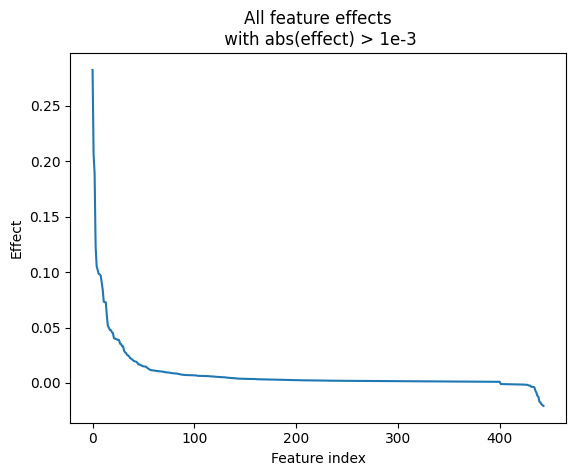

In [11]:
all_eff = all_feature_effects.cpu().detach().numpy()
all_eff = all_eff[np.abs(all_eff) > 1e-3]
plt.plot(all_eff)
plt.title("All feature effects\n with abs(effect) > 1e-3")
plt.xlabel('Feature index')
plt.ylabel('Effect')
plt.show()

In [12]:
# List of tuples (feature_layer, feature_index, feature_effects)
effect_tuples = []
for submodule in attns + mlps + resids:
    feature_effects = effects[submodule].mean(dim=(0, 1))
    for i, effect in enumerate(feature_effects):
        effect_tuples.append((submodule, submodule_names[submodule], i, effect.item()))
# sort by effect
effect_tuples.sort(key=lambda x: x[3], reverse=True)

# Faithfulness

In [13]:
def faithfulness(fc, fempty, fm):
    return ((fc - fempty) / (fm - fempty))

In [14]:
# Model performance with all embeddings ablated
def compute_ablation(
        clean_input_ids,
        patch_input_ids,
        model,
        dictionaries,
        metric_fn,
        ablation_idxs,
        keep_idxs = True,
        metric_kwargs = {},
):
    # first run through a test input to figure out which hidden states are tuples
    is_tuple = {}
    with model.trace("_"):
        for submodule in ablation_idxs:
            is_tuple[submodule] = type(submodule.output.shape) == tuple

    if patch_input_ids is not None:
        patch_states = {}
        with t.no_grad(), model.trace(patch_input_ids, **tracer_kwargs):
            for submodule in submodules:
                dictionary = dictionaries[submodule]
                x = submodule.output
                if type(x.shape) == tuple:
                    x = x[0]
                x_hat, f = dictionary(x, output_features=True)
                patch_states[submodule] = f.save()

    with t.no_grad(), model.trace(clean_input_ids, **tracer_kwargs):
        for submodule in ablation_idxs:
            dictionary = dictionaries[submodule]
            x = submodule.output
            if is_tuple[submodule]:
                x = x[0]
            f = dictionary.encode(x)
            residual = x - dictionary(x)

            # Ablation
            if keep_idxs:
                mask = t.zeros_like(f, dtype=t.bool)
                mask[..., ablation_idxs[submodule]] = True
            else:
                mask = t.ones_like(f, dtype=t.bool)
                mask[..., ablation_idxs[submodule]] = False
            if patch_input_ids is not None:
                f[..., ~mask] = patch_states[submodule].value[..., ~mask]
            else:
                f[..., ~mask] = t.zeros_like(f)[..., ~mask]

            x_hat = dictionary.decode(f)
            x_recon = residual + x_hat
            if is_tuple[submodule]:
                submodule.output[0][:] = x_recon
            else:
                submodule.output = x_recon
        metric_values = metric_fn(model, **metric_kwargs).save()
        
    return metric_values

def run_ablation(present_prefixes, past_prefixes, present_answers, past_answers, ablation_idxs, keep_idxs = True):
    metric_values_past = compute_ablation(
        past_prefixes,
        present_prefixes,
        model,
        dictionaries,
        logit_diff_metric,
        ablation_idxs,
        keep_idxs = keep_idxs,
        metric_kwargs={'clean_answers': past_answers, 'patch_answers': present_answers},
    )
    return metric_values_past.mean()

def compute_faithfulness_scores_by_nfeats(present_prefixes, past_prefixes, present_answers, past_answers, n_steps, min_layer=0):
    nfeats=t.logspace(0, 6, n_steps, dtype=t.int)
    dataset = dict(
        present_prefixes = present_prefixes,
        past_prefixes = past_prefixes,
        present_answers = present_answers,
        past_answers = past_answers,
    )
    faithfulness_submodules = attns[min_layer:] + mlps[min_layer:] + resids[min_layer:]

    # Compute baseline and skyline
    ablation_idxs = {submodule: t.tensor([], dtype=t.int) for submodule in faithfulness_submodules}
    fempty = run_ablation(**dataset, ablation_idxs=ablation_idxs, keep_idxs = True)
    fmodel = run_ablation(**dataset, ablation_idxs=ablation_idxs, keep_idxs = False)
    print(f'F(empty): {fempty} (Mean logit diff with all features (starting min layer) ablated)')
    print(f'F(full): {fmodel} (Mean logit diff of clean forward pass)')

    # Compute faithfulness scores
    faithfulness_scores = []
    fcs = []
    prev_n = 0
    for n in nfeats:
        for eff in effect_tuples[prev_n:n]: # all effects
            submodule = eff[0]
            ablation_idxs[submodule] = t.cat((ablation_idxs[submodule], t.tensor([eff[2]]))).flatten()
        prev_n = n

        logit_diff_mean = run_ablation(**dataset, ablation_idxs=ablation_idxs, keep_idxs=True)
        fcs.append(logit_diff_mean.detach().cpu())
        faithfulness_score = faithfulness(logit_diff_mean, fempty, fmodel).detach().cpu()
        faithfulness_scores.append(faithfulness_score)

    return faithfulness_scores, nfeats, fcs, fempty, fmodel

### Zero ablation

In [15]:
faithfulness_scores_zero, number_of_features_zero, _, _, _ = compute_faithfulness_scores_by_nfeats(
    present_prefixes=None,
    past_prefixes=past_prefixes,
    present_answers=present_answers,
    past_answers=past_answers,
    n_steps=20, # used 200 steps for the report
)

F(empty): -0.8474563956260681 (Mean logit diff with all features (starting min layer) ablated)
F(full): -3.7816269397735596 (Mean logit diff of clean forward pass)


In [16]:
min(faithfulness_scores_zero), max(faithfulness_scores_zero)

(tensor(-0.), tensor(1.0246))

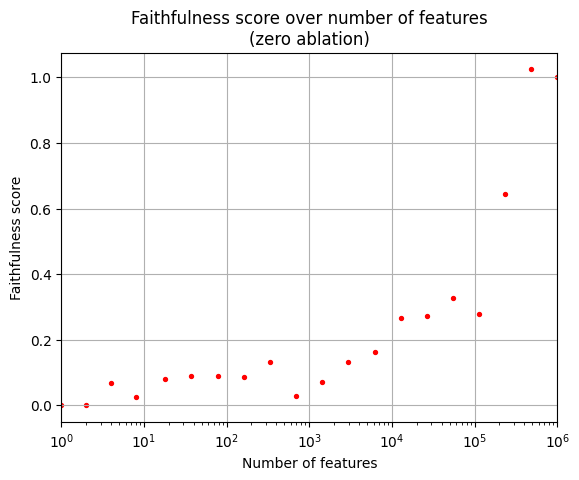

In [17]:
# Plot faithfulness score over number of features
plt.scatter(number_of_features_zero, faithfulness_scores_zero, color='red', s=8)
plt.title("Faithfulness score over number of features\n(zero ablation)")
plt.xscale('log')
plt.xlim(1, 1e6)
plt.xlabel("Number of features")
plt.ylabel("Faithfulness score")
plt.grid()
plt.show()

### Resample ablation

In [18]:
faithfulness_scores, number_of_features, fcs, fempty, fmodel = compute_faithfulness_scores_by_nfeats(**dataset, n_steps=20) # used 200 steps for the report

F(empty): 1.320974349975586 (Mean logit diff with all features (starting min layer) ablated)
F(full): -3.7816269397735596 (Mean logit diff of clean forward pass)


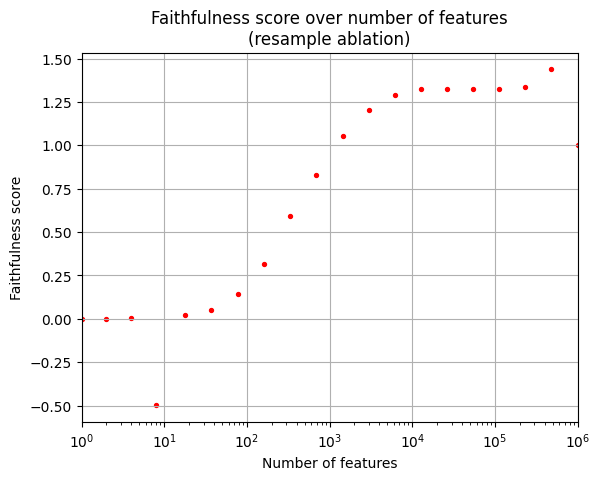

In [19]:
# Plot faithfulness score over number of features
plt.scatter(number_of_features, faithfulness_scores, color='red', s=8)
plt.title("Faithfulness score over number of features\n(resample ablation)")
plt.xscale('log')
plt.xlabel("Number of features")
plt.ylabel("Faithfulness score")
plt.xlim(1, 1e6)
plt.grid()
plt.show()

# Spike investigation

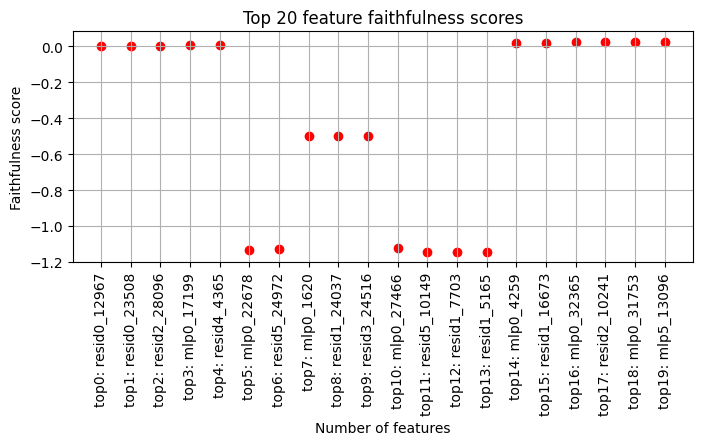

In [20]:
# Indices array
top_indices = {submodule: t.tensor([], dtype=t.int) for submodule in attns + mlps + resids}
top_faithfulness_scores = []
top_indices_range = np.arange(20)

for i in top_indices_range:
    top_indices[effect_tuples[i][0]] = t.cat((top_indices[effect_tuples[i][0]], t.tensor([effect_tuples[i][2]], dtype=t.int)))
    logit_diff_mean = run_ablation(**dataset, ablation_idxs=top_indices, keep_idxs = True)
    faithfulness_score = faithfulness(logit_diff_mean, fempty, fmodel).detach().cpu()
    top_faithfulness_scores.append(faithfulness_score)

plt.figure(figsize=(8, 3))
plt.scatter(top_indices_range, top_faithfulness_scores, color='red')
plt.title("Top 20 feature faithfulness scores")
plt.xticks(top_indices_range, [f"top{i}: {effect_tuples[i][1]}_{effect_tuples[i][2]}" for i in top_indices_range], rotation=90)
plt.xlabel("Number of features")
plt.ylabel("Faithfulness score")
plt.grid()
plt.show()

# Positional information

In [21]:
pref_idx = 0
past_prefixes_tokenized = model.tokenizer.tokenize(past_prefixes[0])
pos_list = range(len(past_prefixes_tokenized))
example_prompt = list(zip(pos_list, past_prefixes_tokenized))
for i, prompt in example_prompt:
    print(f"pos{i}: {prompt}")

pos0: While
pos1: Ġthe
pos2: Ġteacher
pos3: Ġwas
pos4: Ġtalking
pos5: ,
pos6: Ġthe
pos7: Ġstudent


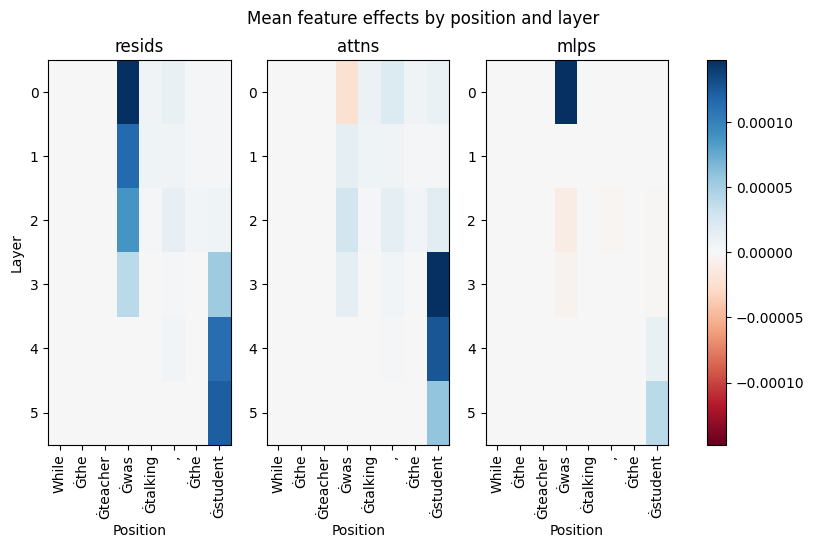

In [22]:
# Assuming 'effects' dictionary and 'example_prompt' are defined
# Define submodules for plotting
submodule_types = ['resids', 'attns', 'mlps']
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 3 subplots in a row

for ax, submodule_type in zip(axes, submodule_types):
    feature_effects = []
    for submodule in globals()[submodule_type]:
        effs = effects[submodule].mean(dim=(0, 2)).cpu().detach().numpy()
        feature_effects.append(effs)
    
    # Display the feature effects
    im = ax.imshow(feature_effects, aspect='auto', cmap='RdBu')
    
    # Create a colorbar
    max_val = max([abs(eff).max() for eff in feature_effects])
    im.set_clim(-max_val, max_val)
    
    # Set subplot title
    ax.set_title(f'{submodule_type}')
    
    # Set axis labels
    ax.set_xlabel('Position')
    xticklabels = [f"{i}: {prompt}" for i, prompt in example_prompt]
    ax.set_xticks(range(len(past_prefixes_tokenized)), past_prefixes_tokenized, rotation=90)
axes[0].set_ylabel('Layer')
fig.suptitle('Mean feature effects by position and layer')

# Create a colorbar for all subplots
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()
